# Part 2: Indexing and Evaluation

## Indexing

In [1]:
import pandas as pd
import re
import json
from array import array

import numpy as np
import math
from numpy import linalg as la

from collections import defaultdict
import collections

import nltk
nltk.download('stopwords')

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

C:\Users\mirei\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mirei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Open txt and save it as a pandas dataframe
with open('inputs/dataset_tweets_WHO.txt') as f:
    json_data = json.load(f)
    
data = pd.DataFrame(json_data).transpose()
#data.info()

In [3]:
data = pd.concat([data.drop(['entities'], axis=1), data['entities'].apply(pd.Series)], axis=1)
#data.info()

In [4]:
data = pd.concat([data.drop(['user'], axis=1), data['user'].apply(pd.Series)], axis=1)
#data.info()

### Clean tweets

In [5]:
#function to process the tweets
def build_terms(line):
    """
    Preprocess the tweets removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """
    
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    
    ## START CODE
    line= str.lower(line) # Transform in lowercase
    line = re.sub('[^\w\s]','', line) # removing punctuation
    line= line.split() # Tokenization
    line= [l for l in line if l not in stop_words] # remove stopwords
    line= [stemmer.stem(word) for word in line] # stemming
    

    ## END CODE
    return line

### 1. Create inverted index

In [6]:
def create_index(lines):
    """
    Implement the inverted index
    
    Argument:
    lines -- collection of tweets
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the positions) as values.
    """
    index = defaultdict(list)
    title_index = {}  
    for line in lines:  # Remember, lines contain all documents
        terms = build_terms(''.join(line)) 
        title_index[page_id]=terms  
        
        ## ===============================================================        
        ## create the index for the current page and store it in current_page_index (current_page_index)
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is 
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms):
            try:
                # if the term is already in the index for the current page (current_page_index)
                # append the position to the corresponding list
                
        ## START CODE
                current_page_index[term][1].append(position)  
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in Python)
            
        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)
        
        ## END CODE                    
                    
    return index, title_index

### 2.3 TF-IDF ranking

In [7]:
def create_index_tfidf(lines, num_documents):
    """
    Implement the inverted index and compute tf, df and idf
    
    Argument:
    lines -- collection of tweets
    num_documents -- total number of documents
    
    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of document these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each document
    df - number of documents each term appear in
    idf - inverse document frequency of each term
    """

    index = defaultdict(list)
    tf = defaultdict(list)  #term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  #document frequencies of terms in the corpus
    title_index = defaultdict(str)
    idf = defaultdict(float)

    page_id = 0
    for line in lines:  # Remember, lines contain all documents
        terms = build_terms(''.join(line)) 
        title_index[page_id]=terms  
        

        ## ===============================================================        
        ## create the index for the *current page* and store it in current_page_index
        ## current_page_index ==> { ‘term1’: [current_doc, [list of positions]], ...,‘term_n’: [current_doc, [list of positions]]}

        ## Example: if the curr_doc has id 1 and his text is 
        ##"web retrieval information retrieval":

        ## current_page_index ==> { ‘web’: [1, [0]], ‘retrieval’: [1, [1,4]], ‘information’: [1, [2]]}

        ## the term ‘web’ appears in document 1 in positions 0, 
        ## the term ‘retrieval’ appears in document 1 in positions 1 and 4
        ## ===============================================================

        current_page_index = {}

        for position, term in enumerate(terms):  
            try:
                # if the term is already in the dict append the position to the corresponding list
                current_page_index[term][1].append(position)
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                current_page_index[term]=[page_id, array('I',[position])] #'I' indicates unsigned int (int in Python)

        # normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_page_index.items():
            # posting will contain the list of positions for current term in current document. 
            # posting ==> [current_doc, [list of positions]] 
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_page_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm,4)) ## SEE formula (1) above REVISAAAAAAAR
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] = df[term] + 1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)
            
        page_id += 1

    return index, tf, df, idf, title_index

In [8]:
lines = list(data['full_text'])
num_documents = len(lines)
index, tf, df, idf, title_index = create_index_tfidf(lines, num_documents)

Here we will look at the tf of all the words used in the different keys and sort them in a descending order.

In [9]:
#average  of tf for each word
avgs = []

for key in tf.keys():
    av = np.mean(tf[key])
    avgs.append(av)
    
avgs_sorted = sorted(range(len(avgs)), key=lambda k:avgs[k])

### Apply TF-IDF ranking

In [10]:
def rank_documents(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title
    
    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaining elements would became 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query. 
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex]=query_terms_count[term]/query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26            
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc 
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot
    
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs, doc_scores

In [11]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms ahd their scores
    So, we will get the list of documents for each query term, and take the intersection of them.
    """
    query = build_terms(query)
    docs = set()
    
    for term in query:        
        try:
            # store in term_docs the ids of the docs that contain "term"                        
            term_docs=[posting[0] for posting in index[term]]
            
            # docs = docs Union term_docs
            if len(docs) == 0:
                docs |= set(term_docs)
            else:
                docs = docs.intersection(set(term_docs))
                
            
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, doc_scores = rank_documents(query, docs, index, idf, tf, title_index)
    return ranked_docs, doc_scores

In [12]:
query1 = 'vaccine covid19' #284
query2 = 'color pandemic' #234
query3 = 'vaccine pandemic' #50
query4 = 'color risk' #111
query5 = 'risk covid19' #47

queries = [query1, query2, query3, query4, query5]

top = 10

ranked_docs_list = []
scores_list = []

for query in queries:

    ranked_docs, doc_scores = search_tf_idf(query, index)
    ranked_docs_list.append(ranked_docs)
    scores_list.append(doc_scores)

    print('Top', top, 'results out of', len(ranked_docs), 'for the search query:\n', query)
    
#ranked_docs_list

Top 10 results out of 284 for the search query:
 vaccine covid19
Top 10 results out of 234 for the search query:
 color pandemic
Top 10 results out of 50 for the search query:
 vaccine pandemic
Top 10 results out of 111 for the search query:
 color risk
Top 10 results out of 47 for the search query:
 risk covid19


In [13]:
for i in range(len(queries)):
    print(queries[i])
    ranked_docs = ranked_docs_list[i]
    for doc in ranked_docs:
        print(data.iloc[doc][['full_text', 'name', 'created_at', 'hashtags', 'favorite_count', 'retweet_count', 'url']])

vaccine covid19
full_text         The mRNA #COVID19 vaccines are as safe as othe...
name                                World Health Organization (WHO)
created_at                           Fri Jul 23 08:32:05 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                  [{'text': 'COVID19', 'indices': [9, 17]}]
favorite_count                                                  419
retweet_count                                                   240
url                                         https://t.co/wVulKuROWG
Name: 1833, dtype: object
full_text         RT @WHOWPRO: Encourage your loved ones to get ...
name                                World Health Organization (WHO)
created_at                           Fri Aug 13 15:37:03 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [65, 73]}]
favorite_count                                                    0
retwee

Name: 1849, dtype: object
full_text         @DrTedros So far, over 75% of the #COVID19 vac...
name                                World Health Organization (WHO)
created_at                           Fri Aug 13 13:21:46 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [34, 42]}, {'t...
favorite_count                                                  235
retweet_count                                                   125
url                                         https://t.co/wVulKuROWG
Name: 1348, dtype: object
full_text         "The major hurdle to recovery remains equitabl...
name                                World Health Organization (WHO)
created_at                           Mon Jun 28 08:19:38 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [58, 66]}, {'t...
favorite_count                                                  

Name: 1947, dtype: object
full_text         @Olympics @DrTedros "More than 3.5 billion #CO...
name                                World Health Organization (WHO)
created_at                           Wed Jul 21 00:25:57 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [43, 51]}, {'t...
favorite_count                                                   75
retweet_count                                                    46
url                                         https://t.co/wVulKuROWG
Name: 1927, dtype: object
full_text         @DrTedros @antonioguterres "Today, WHO is laun...
name                                World Health Organization (WHO)
created_at                           Thu Oct 07 13:49:23 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [83, 91]}]
favorite_count                                                  

Name: 2052, dtype: object
full_text         Here is what WHO Chief Scientist @doctorsoumya...
name                                World Health Organization (WHO)
created_at                           Wed Jul 14 10:24:34 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [78, 86]}]
favorite_count                                                  375
retweet_count                                                   217
url                                         https://t.co/wVulKuROWG
Name: 2017, dtype: object
full_text         RT @DrTedros: We urgently need to scale up #CO...
name                                World Health Organization (WHO)
created_at                           Thu Jul 22 06:41:52 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [43, 51]}]
favorite_count                                                  

Name: 1606, dtype: object
full_text         People with disabilities are disproportionatel...
name                                World Health Organization (WHO)
created_at                           Tue Aug 24 13:36:47 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                 [{'text': 'COVID19', 'indices': [60, 68]}]
favorite_count                                                  912
retweet_count                                                   336
url                                         https://t.co/wVulKuROWG
Name: 1113, dtype: object
full_text         To stop the spread of #COVID19, all prevention...
name                                World Health Organization (WHO)
created_at                           Tue Aug 24 13:53:14 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [22, 30]}, {'t...
favorite_count                                                  

Name: 1961, dtype: object
full_text         @DrTedros @IFPMA @G7 "Earlier this week, I had...
name                                World Health Organization (WHO)
created_at                           Wed Sep 08 14:53:53 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [186, 194]}, {...
favorite_count                                                   67
retweet_count                                                    26
url                                         https://t.co/wVulKuROWG
Name: 837, dtype: object
full_text         @DrTedros "This will likely lead to serious re...
name                                World Health Organization (WHO)
created_at                           Mon Sep 13 15:17:12 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [181, 189]}, {...
favorite_count                                                   

Name: 1012, dtype: object
full_text         RT @DrTedros: The work that goes into pandemic...
name                                World Health Organization (WHO)
created_at                           Wed Sep 01 20:53:09 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                                                         []
favorite_count                                                    0
retweet_count                                                    37
url                                         https://t.co/wVulKuROWG
Name: 954, dtype: object
full_text         RT @DrTedros: Glad to appoint @Chikwe_I as Hea...
name                                World Health Organization (WHO)
created_at                           Wed Sep 01 20:53:30 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags                                                         []
favorite_count                                                   

full_text         @DrTedros @jensspahn @ACTAccelerator "The Comm...
name                                World Health Organization (WHO)
created_at                           Thu Jul 15 12:21:58 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'COVID19', 'indices': [100, 108]}]
favorite_count                                                   47
retweet_count                                                    21
url                                         https://t.co/wVulKuROWG
Name: 1984, dtype: object
full_text         @Olympics @DrTedros "And yet, 19 months into t...
name                                World Health Organization (WHO)
created_at                           Wed Jul 21 00:22:26 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [49, 57]}, {'t...
favorite_count                                                   71
retweet_count         

Name: 1051, dtype: object
full_text         @UNFPA For every woman who dies of 🤰🏼 related ...
name                                World Health Organization (WHO)
created_at                           Tue Oct 05 12:14:54 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags               [{'text': 'COVID19', 'indices': [132, 140]}]
favorite_count                                                  193
retweet_count                                                    54
url                                         https://t.co/wVulKuROWG
Name: 236, dtype: object
full_text         Those at greatest risk of drowning are often t...
name                                World Health Organization (WHO)
created_at                           Sun Jul 25 12:24:32 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'DrowningPrevention', 'indices': [18...
favorite_count                                                  2

Name: 236, dtype: object
full_text         @DrTedros So far, over 75% of the #COVID19 vac...
name                                World Health Organization (WHO)
created_at                           Fri Aug 13 13:21:46 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [34, 42]}, {'t...
favorite_count                                                  235
retweet_count                                                   125
url                                         https://t.co/wVulKuROWG
Name: 1348, dtype: object
full_text         Patients who are critically ill with severe #C...
name                                World Health Organization (WHO)
created_at                           Mon Sep 13 09:48:20 +0000 2021
created_at                           Wed Apr 23 19:56:27 +0000 2008
hashtags          [{'text': 'COVID19', 'indices': [44, 52]}, {'t...
favorite_count                                                  2

## Evaluation

### Create the dataset

In [14]:
#create empty dataset with the docs ids
ground_truth = data
ground_truth['doc_id'] = ground_truth.index
ground_truth = ground_truth['doc_id']
gt = pd.DataFrame()
gt['doc_id'] = ground_truth

In [15]:
#fill a column for each query on binary relevance

y_true = np.zeros(len(gt)) #column to be filled
pred_score = np.zeros(len(gt)) #column to be filled

for i in range(len(queries)):
    ranked_docs = ranked_docs_list[i]  #get the docs that were relevant for that query
    
    sc_values = []
    for x in scores_list[i]:
        sc_values.append(x[0])  #get the scores from the ranking of the queries for this docs
   
    for j in range(len(y_true)):  #for each document
        if j in ranked_docs:      #if it is relevant
            y_true[j] = 1
            idx = ranked_docs.index(j)
            pred_score[j] = sc_values[idx]

    gt['y_true_'+str(i)] = y_true
    gt['predicted_relevance_'+str(i)] = pred_score
gt

,doc_id,y_true_0,predicted_relevance_0,y_true_1,predicted_relevance_1,y_true_2,predicted_relevance_2,y_true_3,predicted_relevance_3,y_true_4,predicted_relevance_4
0,0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,1.285659,1.0,1.285659
1,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,2,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,1.083293,1.0,1.083293
3,3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2394,2394,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2395,2395,0.0,0.0,1.0,0.878735,1.0,0.878735,1.0,0.878735,1.0,0.878735
2396,2396,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2397,2397,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000


### Precision @k

In [16]:
def precision_at_k(y_true, y_score, k=10):
    '''    
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    precision @k : float
    
    '''    
    order = np.argsort(y_score)
    order = order[::-1]
    y_true = np.take(y_true, order[:k])
    relevant = sum(y_true == 1)
    precision = float(relevant)/k
    return precision

In [17]:
k=750

for i in range(len(queries)):
    print('for query: ', queries[i])

    print("==> Precision@{}: {}\n".format(k,precision_at_k(gt['y_true_'+str(i)], gt['predicted_relevance_'+str(i)], k)))

for query:  vaccine covid19
==> Precision@750: 0.37866666666666665

for query:  color pandemic
==> Precision@750: 0.6373333333333333

for query:  vaccine pandemic
==> Precision@750: 0.6373333333333333

for query:  color risk
==> Precision@750: 0.7533333333333333

for query:  risk covid19
==> Precision@750: 0.7533333333333333



### Avg precision @k

In [18]:
def avg_precision_at_k(y_true, y_score, k=10):
    
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    average precision @k : float
    '''
    
    gtp = sum(y_true==1)
    order = np.argsort(y_score)
    order = order[::-1]
    y_true = np.take(y_true, order[:k])            

    ## if all docs are not relevant
    if gtp==0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(y_true)):
        if y_true[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i+1)
    
    avg_precision_at_k = prec_at_i / gtp
    
    return avg_precision_at_k

In [19]:
k=300

for i in range(len(queries)):
    print('for query: ', queries[i])

    print("==> Average Precision@{}: {}\n".format(k, avg_precision_at_k(gt['y_true_'+str(i)], gt['predicted_relevance_'+str(i)], k)))

for query:  vaccine covid19
==> Average Precision@300: 1.0

for query:  color pandemic
==> Average Precision@300: 0.6276150627615062

for query:  vaccine pandemic
==> Average Precision@300: 0.6276150627615062

for query:  color risk
==> Average Precision@300: 0.5309734513274337

for query:  risk covid19
==> Average Precision@300: 0.5309734513274337



### MAP @k

In [20]:
def map_at_k(queries, gt, k=10):
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        y_true: actual score of the document for the query (ground truth).
    
    Returns
    -------
    mean average precision @k : float
    '''
    avp = []
    for i in range(len(queries)): #loop over all query id
        y_true = gt['y_true_'+str(i)]  # select data for current query
        pred_rel = gt['predicted_relevance_'+str(i)]  # select data for current query
        avp.append(avg_precision_at_k(y_true, pred_rel, k)) #append average precision for current query
    
    map_k = np.sum(avp) / len(avp)
    
    return map_k, avp # return mean average precision

In [21]:
map_k, avp = map_at_k(queries, gt, 300)
map_k

0.6634354056355759

### Mean Reciprocal Rank (MRR)

In [22]:
def rr_at_k(y_true, y_score, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.
    
    Returns
    -------
    Reciprocal Rank for current query
    '''

    order = np.argsort(y_score)
    order = order[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score and take first k.
    if np.sum(y_true) == 0: # if there are not relevant doument return 0
        return 0
    
    mrr = 1 / (np.argmax(y_true == 1) + 1)
    
    return mrr 

In [23]:
k=15

for i in range(len(queries)):
    print('for query: ', queries[i])
    print("==> Mean Reciprocal Rank @{}: {}\n".format(k, rr_at_k(gt['y_true_'+str(i)], gt['predicted_relevance_'+str(i)], k)))

for query:  vaccine covid19
==> Mean Reciprocal Rank @15: 1.0

for query:  color pandemic
==> Mean Reciprocal Rank @15: 1.0

for query:  vaccine pandemic
==> Mean Reciprocal Rank @15: 1.0

for query:  color risk
==> Mean Reciprocal Rank @15: 1.0

for query:  risk covid19
==> Mean Reciprocal Rank @15: 1.0



### Normalized Discounted Cumulative Gain (NDCG)

In [24]:
def dcg_at_k(y_true, y_score,  k=10):
    order = np.argsort(y_score)
    order = order[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = (2 ** y_true) - 1 # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(y_true)) + 2) # Compute denominator
    return np.sum(gain / discounts) #return dcg@k


def ndcg_at_k(y_true, y_score, k=10):    
    dcg_max = dcg_at_k(y_true, y_true,  k) # Ideal dcg
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score,  k) / dcg_max, 4)  # return ndcg@k

In [25]:
k=1000

for i in range(len(queries)):
    print('for query: ', queries[i])
    print("==> ndcg@{}: {}\n".format(k, ndcg_at_k(gt['y_true_'+str(i)], gt['predicted_relevance_'+str(i)], k)))

for query:  vaccine covid19
==> ndcg@1000: 1.0

for query:  color pandemic
==> ndcg@1000: 1.0

for query:  vaccine pandemic
==> ndcg@1000: 1.0

for query:  color risk
==> ndcg@1000: 1.0

for query:  risk covid19
==> ndcg@1000: 1.0



### Vector representation

In [26]:
#as we were cleaning inside the indexing function we hadn't actually saved the cleaned text
clean_t = data['full_text'].map(lambda x: build_terms(x))

In [31]:
import gensim
from gensim.models import Word2Vec

model = Word2Vec(clean_t, min_count=1) # represent all the words (terms) as vectors
words = list(model.wv.vocab)
print(words[0:10])

['intern', 'day', 'disast', 'risk', 'reduct', 'openwho', 'launch', 'multiti', 'core', 'curriculum']


C:\Users\mirei\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass perplexity=50, early_exaggeration=30 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


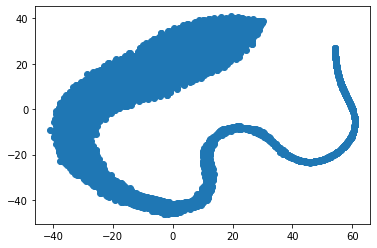

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = model.wv[model.wv.vocab]

tsne = TSNE(2,50,30)
X_tsne = tsne.fit_transform(X) # apply tsne to the model and plot

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [29]:
tweets = []

for i in range(len(clean_t)):
    try:
        array = model[clean_t[i][0]].copy()
        for j in clean_t:
            array += model[j].copy()
        array = array/len(clean_t[i])
        tweets.append(array)
        
    except:
        continue

C:\Users\mirei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
C:\Users\mirei\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


C:\Users\mirei\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass perplexity=50, early_exaggeration=30 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


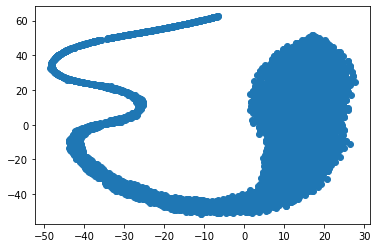

In [30]:
tsne = TSNE(2,50,30)
X_tsne = tsne.fit_transform(X) # apply tsne to the model and plot

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()